In [138]:
#Import libraries
from data_loader import FootballDataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Masking, GRU, Dense, Dropout, TimeDistributed, RepeatVector
)
import matplotlib.pyplot as plt


Reading game 1: Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Loading Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Data read.
Time shape: (155541, 2)
Ball shape: (155541, 6)
Team shape: (155541, 75)
Opponent shape: (155541, 80)
Total shape: (88002, 163)

=== DataFrame Overview ===
Shape: (88002, 163)

Columns:
['Time', 'half', 'Ball_x', 'Ball_y', 'game', 'Ball_z', 'Ball_Speed?', 'Ball_Col5', 'FCKplayer_1_x', 'FCKplayer_1_y', 'FCKplayer_1_z', 'FCKplayer_1_speed_x', 'FCKplayer_1_number', 'FCKplayer_2_x', 'FCKplayer_2_y', 'FCKplayer_2_z', 'FCKplayer_2_speed_x', 'FCKplayer_2_number', 'FCKplayer_4_x', 'FCKplayer_4_y', 'FCKplayer_4_z', 'FCKplayer_4_speed_x', 'FCKplayer_4_number', 'FCKplayer_8_x', 'FCKplayer_8_y', 'FCKplayer_8_z', 'FCKplayer_8_speed_x', 'FCKplayer_8_number', 'FCKplayer_10_x', 'FCKplayer_10_y', 'FCKplayer_10_z', 'FCKplayer_10_speed_x', 'FCKplayer_10_number', 'FCKplayer_11_x', 'FCKplayer_11_y', 'FCKplayer_11_z', 'FCKplayer_11_speed_x', 'FCKplayer_11_number', 'FCKplayer_13_x', 'FCKpl

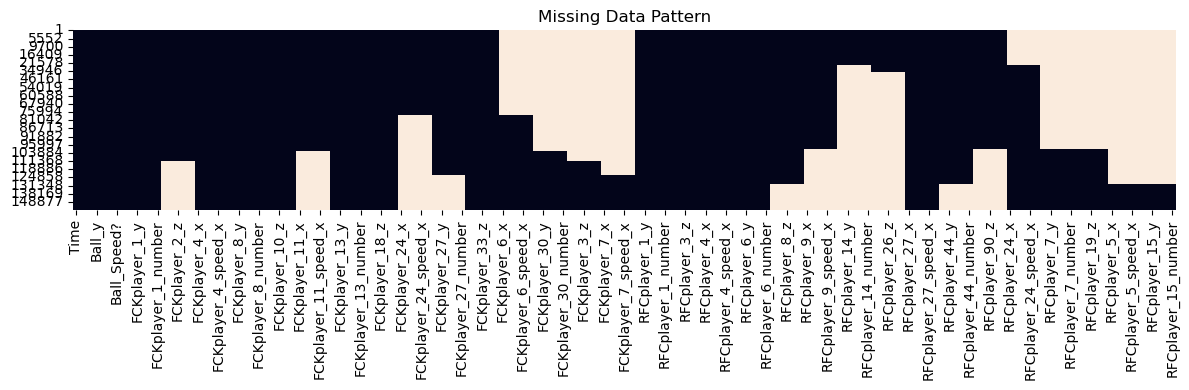

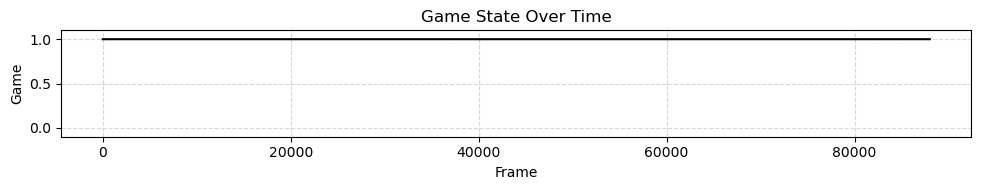

In [139]:
#Getting the data
data_dir = r"\Users\kirlo\Documents\Sanvi University Work\Year 3\AML\final project\FootballData\RestructuredData_2425"  # replace with your actual data directory
team = "FCK"         
data_retriever = FootballDataLoader(data_dir, team)
all_games = data_retriever.load_all_games()
game = all_games[0]

In [140]:
#Dropping unnecessary columns
position_columns = [
    col for col in game.columns 
    if (
        ('player' in col and (col.endswith('_x') or col.endswith('_y') or 'speed' in col)) or
        ('ball' in col.lower() and (col.endswith('_x') or col.endswith('_y') or col.endswith('_z') or 'speed' in col.lower()))
    )
]

game_reduced = game[position_columns]

In [141]:
game_reduced.columns

Index(['Ball_x', 'Ball_y', 'Ball_z', 'Ball_Speed?', 'FCKplayer_1_x',
       'FCKplayer_1_y', 'FCKplayer_1_speed_x', 'FCKplayer_2_x',
       'FCKplayer_2_y', 'FCKplayer_2_speed_x', 'FCKplayer_4_x',
       'FCKplayer_4_y', 'FCKplayer_4_speed_x', 'FCKplayer_8_x',
       'FCKplayer_8_y', 'FCKplayer_8_speed_x', 'FCKplayer_10_x',
       'FCKplayer_10_y', 'FCKplayer_10_speed_x', 'FCKplayer_11_x',
       'FCKplayer_11_y', 'FCKplayer_11_speed_x', 'FCKplayer_13_x',
       'FCKplayer_13_y', 'FCKplayer_13_speed_x', 'FCKplayer_18_x',
       'FCKplayer_18_y', 'FCKplayer_18_speed_x', 'FCKplayer_24_x',
       'FCKplayer_24_y', 'FCKplayer_24_speed_x', 'FCKplayer_27_x',
       'FCKplayer_27_y', 'FCKplayer_27_speed_x', 'FCKplayer_33_x',
       'FCKplayer_33_y', 'FCKplayer_33_speed_x', 'FCKplayer_6_x',
       'FCKplayer_6_y', 'FCKplayer_6_speed_x', 'FCKplayer_30_x',
       'FCKplayer_30_y', 'FCKplayer_30_speed_x', 'FCKplayer_3_x',
       'FCKplayer_3_y', 'FCKplayer_3_speed_x', 'FCKplayer_7_x',
       'FCK

In [142]:
#Standardising data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_game = pd.DataFrame(scaler.fit_transform(game_reduced), columns=game_reduced.columns)

In [ ]:
#Creating the autoencoder sequence
window_size = 10 #how far back in time the neural network will look to predict the future
horizon = 10 # how far into the future the neural network will predict

#I kept window size and horizon small for my laptop sake but you can change them to what you need for the xgs

#Essentially the neural network will take window_size number of time steps in the past and predict beginning from horizon time steps after the last training time step
def sequences(data, time_steps, horizon):
    inputs = []
    targets = []
    for i in range(len(data) - time_steps - horizon + 1):
        input_seq = data[i : i + time_steps]
        target_seq = data[i + horizon : i + time_steps + horizon]
        inputs.append(input_seq)
        targets.append(target_seq)
    return np.array(inputs), np.array(targets)

times = normalized_game.iloc[1000:] #Here you can control where you want to start sequence generation. 1000: means it starts from the 1000th timestep
past, future = sequences(times.values, window_size, horizon)



In [ ]:
#padding the sequences
pad_value = -999.9 #Set this to 0 if you want the predictions to be better. Doesnt make much sense to me though
past = np.nan_to_num(past, nan=pad_value)
future = np.nan_to_num(future, nan=pad_value)

pad_value = np.float32(pad_value)
past = past.astype(np.float32)
future = future.astype(np.float32)

In [ ]:
#Building neural network
model = Sequential([
    Masking(mask_value=pad_value, input_shape=(past.shape[1], past.shape[2])),
    GRU(64, return_sequences=False),
    RepeatVector(past.shape[1]),  
    GRU(64, return_sequences=True),
    TimeDistributed(Dense(past.shape[2]))  #
])
model.compile(optimizer='adam', loss='mse')



c:\Users\kirlo\anaconda3\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
split_idx = int(len(past) * 0.8)  #Splitting the data so the past is training and future is testing

past_train, past_test = past[:split_idx], past[split_idx:]
future_train, future_test = future[:split_idx], future[split_idx:]

model.fit(past_train, future_train, epochs=25, batch_size=32, validation_split=0.2)


1740/1740 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 281157.3750 - val_loss: 266407.7188


In [147]:
predictions = model.predict(past_test)

544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [ ]:
target_x_colname = game.columns.get_loc('FCKplayer_2_x')
target_y_colname = game.columns.get_loc('FCKplayer_2_y')

#Extracting the first sequence of predictions
sequence_0 = predictions[0]

#Get just the target player's predicted x and y over the window
target_x_predictions = sequence_0[:, target_x_colname]
target_y_predictions = sequence_0[:, target_y_colname]


#Getting the actual values for target player
true_sequence_0 = future[0]
true_x = true_sequence_0[:,target_x_colname]
true_y = true_sequence_0[:, target_y_colname]

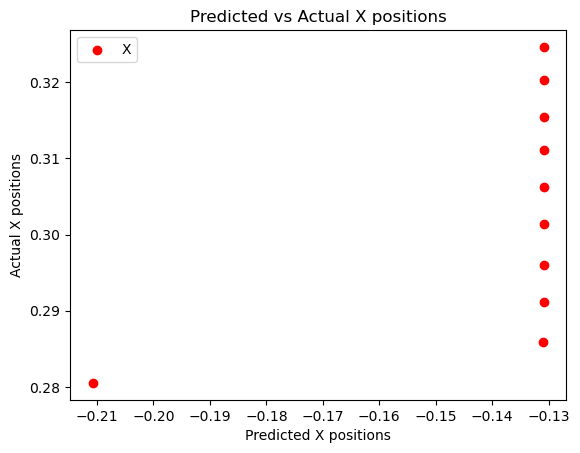

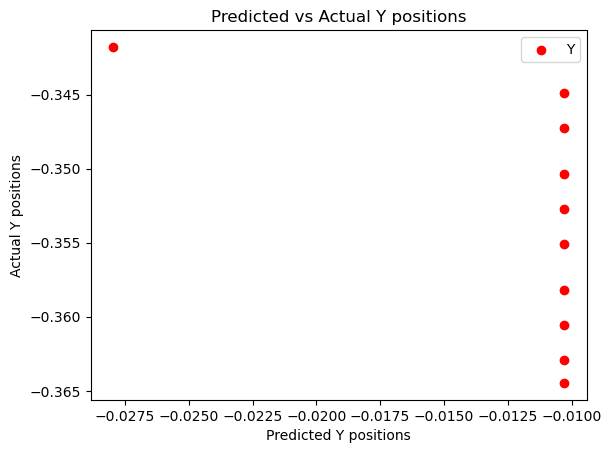

RMSE for X positions: 0.4426066279411316
RMSE for Y positions: 0.3419494032859802


In [149]:
#Evaluating the model
plt.scatter(target_x_predictions,true_x, label='X', color='red')
plt.xlabel('Predicted X positions')
plt.ylabel('Actual X positions')
plt.legend()
plt.title("Predicted vs Actual X positions")
plt.show()

plt.scatter(target_y_predictions,true_y, label='Y', color='red')
plt.xlabel('Predicted Y positions')
plt.ylabel('Actual Y positions')
plt.legend()
plt.title("Predicted vs Actual Y positions")
plt.show()
#finding rmse
from sklearn.metrics import mean_squared_error
rmse_x = np.sqrt(mean_squared_error(true_x, target_x_predictions))
rmse_y = np.sqrt(mean_squared_error(true_y, target_y_predictions))
print(f"RMSE for X positions: {rmse_x}")
print(f"RMSE for Y positions: {rmse_y}")


In [150]:
#models a bit shit but im gonna try and extract data for everyone for the whole game now
num_samples, seq_len, num_features = predictions.shape
unnormalised_preds = scaler.inverse_transform(predictions.reshape(-1, num_features)).reshape(num_samples, seq_len, num_features)

In [ ]:

flat_preds = unnormalised_preds.reshape(-1, unnormalised_preds.shape[-1])

output_indices = [
    list(range(i + horizon, i + window_size + horizon))
    for i in range(len(normalized_game) - window_size - horizon + 1)
]

test_output_indices = output_indices[split_idx:]

flat_output_indices = np.array(test_output_indices).reshape(-1)

min_len = min(len(flat_output_indices), len(flat_preds))
flat_preds = flat_preds[:min_len]
flat_output_indices = flat_output_indices[:min_len]


df_predictions = pd.DataFrame(flat_preds, columns=game_reduced.columns)

df_predictions["timestamp"] = flat_output_indices

df_predictions = df_predictions.sort_values("timestamp").reset_index(drop=True)



In [152]:
output_df.columns

Index(['output_indices', 'predicted_output', 'start_index'], dtype='object')

In [153]:
df_predictions.head()


,Ball_x,Ball_y,Ball_z,Ball_Speed?,FCKplayer_1_x,FCKplayer_1_y,FCKplayer_1_speed_x,FCKplayer_2_x,FCKplayer_2_y,FCKplayer_2_speed_x,...,RFCplayer_19_x,RFCplayer_19_y,RFCplayer_19_speed_x,RFCplayer_5_x,RFCplayer_5_y,RFCplayer_5_speed_x,RFCplayer_15_x,RFCplayer_15_y,RFCplayer_15_speed_x,timestamp
0,3.992035,2.572032,0.764725,6.862245,-32.297108,0.740859,1.080834,-6.728289,-7.230817,2.393661,...,-2211.074219,-1391.766846,-162.354553,-2312.124756,-640.619995,-114.223419,-2455.697998,-948.399719,-180.786148,69596
1,5.016370,2.539626,0.853229,6.555298,-32.530079,0.579380,1.058662,-4.719081,-7.306666,2.360347,...,-2380.470703,-1499.071533,-174.985764,-2490.934570,-690.553833,-123.196487,-2645.903809,-1020.649902,-194.864044,69597
2,3.992691,2.575814,0.764965,6.860498,-32.298752,0.739692,1.080488,-6.723187,-7.229939,2.393544,...,-2211.667236,-1392.143799,-162.398697,-2312.749756,-640.795288,-114.254707,-2456.370117,-948.654907,-180.835312,69597
3,3.993887,2.582466,0.765386,6.857392,-32.301659,0.737620,1.079877,-6.713957,-7.228405,2.393329,...,-2212.726074,-1392.817871,-162.477524,-2313.867432,-641.108643,-114.310577,-2457.571533,-949.109985,-180.923141,69598
4,5.016383,2.539649,0.853230,6.555292,-32.530083,0.579375,1.058661,-4.719059,-7.306662,2.360346,...,-2380.473145,-1499.072998,-174.985962,-2490.937012,-690.554382,-123.196609,-2645.905762,-1020.650940,-194.864212,69598


In [ ]:
#Putting it in the right shape for you guys
reduction1 = df_predictions.drop(columns=[col for col in game.columns if "RFC" in col])
reduction2 = reduction1.drop(columns=[col for col in reduction1.columns if "ball" in col.lower()])

reduction2.to_csv("Predicted_Positions_Autoencoder.csv", index=False)
